## Imports

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from sqlalchemy import create_engine, text 
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

## Loading data

In [2]:
# Подключаемся к базе данных

engine = create_engine('sqlite:///data/shop_database.db')
conn = engine.connect()

In [3]:
# Загружаем таблицы 

df_pers = pd.read_sql(sql=text('SELECT * FROM personal_data'),con=conn)

In [4]:
df_pers.head()

,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32


In [5]:
df_pers.shape

(89241, 6)

In [6]:
df_coef = pd.read_sql(sql=text('SELECT * FROM personal_data_coeffs'),con=conn)

In [7]:
df_coef.head()

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072


In [8]:
df_coef.shape

(104989, 5)

In [9]:
df_purch = pd.read_sql(sql=text('SELECT * FROM purchases'),con=conn)

In [10]:
df_purch.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [11]:
df_purch.shape

(786260, 7)

In [12]:
# Загружаем утерянные данные

df_lost = pd.read_csv('data\personal_data.csv.gz', compression='gzip', header=0)

In [13]:
df_lost.head()

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32


In [14]:
df_lost.shape

(15748, 5)

In [15]:
# Объединяем данные о клиентах с утерянными данными

df_clients = pd.concat([df_pers, df_lost])

In [16]:
df_clients.shape

(104989, 6)

In [17]:
# Добавляем признак с коэффициентом клиента

df_clients = df_clients.merge(df_coef[['id', 'personal_coef']], on='id', how='inner')

In [18]:
df_clients.head()

,id,gender,age,education,city,country,personal_coef
0,0,0.0,36,среднее,1201,32,0.5072
1,4,0.0,35,среднее,1134,32,0.5072
2,6,1.0,52,среднее,1188,32,0.4304
3,7,0.0,37,среднее,1198,32,0.5072
4,9,0.0,48,среднее,1134,32,0.5072


## Data Preparation

### Working with personal data

In [19]:
df_clients.describe()

,id,gender,age,city,country,personal_coef
count,104989.000000,89241.000000,104989.000000,104989.000000,104989.000000,104989.000000
mean,89084.680967,0.572965,38.016707,1133.788492,31.989075,0.458363
std,51414.198487,0.494650,12.283166,179.309965,0.943848,0.062570
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.233600
25%,44532.000000,0.000000,30.000000,1134.000000,32.000000,0.430400
50%,89158.000000,1.000000,38.000000,1167.000000,32.000000,0.468800
75%,133588.000000,1.000000,46.000000,1188.000000,32.000000,0.507200
max,178004.000000,1.000000,77.000000,1213.000000,51.000000,0.558400


In [20]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104989 entries, 0 to 104988
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   gender         89241 non-null   float64
 2   age            104989 non-null  int64  
 3   education      104989 non-null  object 
 4   city           104989 non-null  int64  
 5   country        104989 non-null  int64  
 6   personal_coef  104989 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 6.4+ MB


Text(0, 0.5, 'Кол-во')

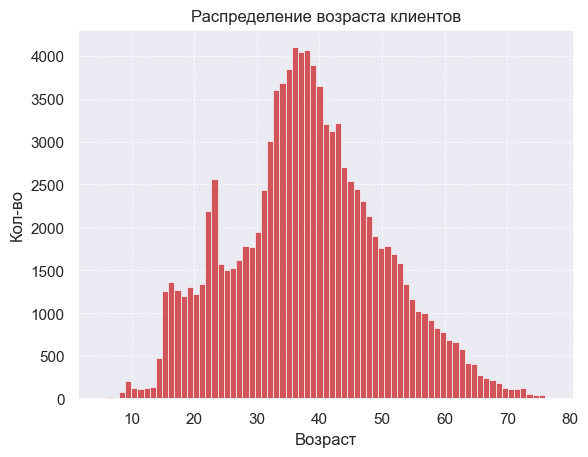

In [21]:
# Визуализируем некоторые распределения

sns.set()
sns.histplot(df_clients['age'], bins=73, color='#C92228')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.title('Распределение возраста клиентов')
plt.xlabel('Возраст')
plt.ylabel('Кол-во')

Text(0, 0.5, 'Кол-во')

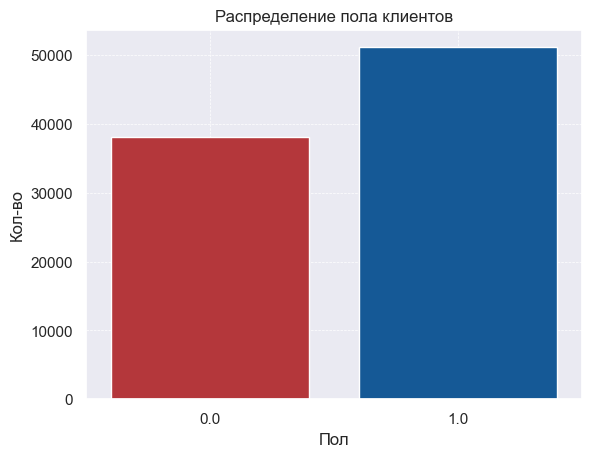

In [22]:
sns.countplot(x = df_clients['gender'],palette=['#C92228',"#005AAB"])
plt.grid(linestyle = '--', linewidth = 0.5)
plt.title('Распределение пола клиентов')
plt.xlabel('Пол')
plt.ylabel('Кол-во')

Text(0, 0.5, 'Кол-во')

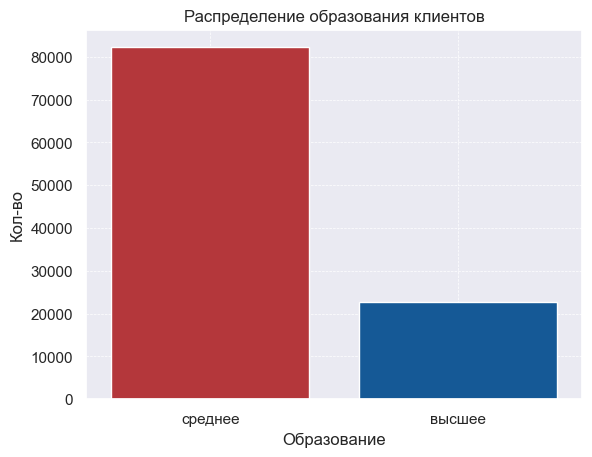

In [23]:
sns.countplot(x = df_clients['education'],palette=['#C92228',"#005AAB"])
plt.grid(linestyle = '--', linewidth = 0.5)
plt.title('Распределение образования клиентов')
plt.xlabel('Образование')
plt.ylabel('Кол-во')

In [24]:
df_clients.duplicated().sum()

0

In [25]:
# Проверяем пропущенные значения

((df_clients.isna().sum() / len(df_clients)) * 100).sort_values(ascending=False)

gender           14.999667
id                0.000000
age               0.000000
education         0.000000
city              0.000000
country           0.000000
personal_coef     0.000000
dtype: float64

In [26]:
for column in df_clients.columns:
    print(column)
    print(df_clients[column].unique(), '\n')

id
[     0      4      6 ... 167019 116355  15885] 

gender
[ 0.  1. nan] 

age
[36 35 52 37 48 39 44 40 49 53 33 19 20 17 50 55 21 34 38 29 62 41 31 43
 16 32 18 30 23 25 42 24 63 45 56 58 22 47 27 51 28 26 54 57 11 46 65 13
 66 64 60 71  5 14 59 61 15 73  9  8 69 68 72 70  7 67 12 10 75  6 74 76
 77] 

education
['среднее' 'высшее'] 

city
[1201 1134 1188 1198 1190 1155  574 1178 1157 1203 1137 1204 1187 1181
 1172 1162 1185 1177 1168 1207 1166 1191 1202 1179  913 1154  338   74
 1205 1167 1159 1141 1142 1180 1150 1160 1199  609 1186 1151    3 1165
 1196 1194 1175 1161 1195 1173   33 1192 1152   48  501 1183 1156 1163
 1197 1200  218 1212    9 1176    1   73    0 1182   12 1153 1189   66
 1164   10 1170 1148 1211 1147 1158  875 1206 1171 1033 1169 1208 1174
    2   34 1133 1184   70   45  204 1135 1145 1092 1098 1093 1017  104
   62  580 1139   11  917  226 1144 1193  804  292   61   59  726   76
  307  536    7  123  515  261  588  174  269 1140  129   84  541  615
  990 1143  550  

In [27]:
# Преобразуем категориальный признак с помощью Label Encoder

le = LabelEncoder()
df_clients['education'] = le.fit_transform(df_clients['education'])

In [28]:
# Разделяем выборку на обучающую и тестовую, для последущего заполнения признака о поле клиента.

df_train = df_clients[~df_clients['gender'].isna()].dropna()
print('df_train shape:',df_train.shape)

df_test = df_clients[df_clients['gender'].isna()]
print('df_test shape:',df_test.shape)

df_train shape: (89241, 7)
df_test shape: (15748, 7)


In [29]:
# В тестовой выборке признак пол не заполнен

x_train = df_train.drop(columns=['gender','id'])
y_train = df_train['gender']

x_test = df_test.drop(columns=['gender','id'])
y_test = df_test['gender']

In [30]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

In [31]:
# Осуществляем подбор гиперпараметров модели

params = {'n_estimators' : [300, 500, 700],
          'max_depth': np.arange(10, 60, 4),
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2)}

rs = RandomizedSearchCV(rfc, params, cv=kf, scoring='f1', n_jobs=-1, error_score='raise')
rs.fit(x_train, y_train)

print('Best params: ', rs.best_params_)
print('Best score: ', rs.best_score_)

Best params:  {'n_estimators': 700, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 50}
Best score:  0.9999315637679035


In [32]:
params = {"loss":["log_loss", "exponential"],
          "learning_rate": [0.01,0.1,1,10,100],
          'max_depth': np.arange(2, 60, 4),
          'max_features': ['sqrt', 'log2', None],
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2),
          "max_features":["log2","sqrt"],
          "criterion": ["friedman_mse",  "squared_error"],
          "subsample":np.arange(0.1, 1, 0.1),
          "n_estimators":[100, 300, 500]}

rs = RandomizedSearchCV(gbc, params, cv=kf, scoring='f1', n_jobs=-1, error_score='raise')
rs.fit(x_train, y_train)

print('Best params: ', rs.best_params_)
print('Best score: ', rs.best_score_)

Best params:  {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 58, 'loss': 'exponential', 'learning_rate': 1, 'criterion': 'friedman_mse'}
Best score:  0.9999413357840817


In [31]:
# Обучаем модель с лучшей оценкой f1 и предсказываем пол клиента на тестовой выборке

model = GradientBoostingClassifier(subsample=0.8, n_estimators=300, min_samples_split=18, min_samples_leaf=4, 
                                   max_features='sqrt', max_depth=58, loss= 'exponential', learning_rate=1,
                                   criterion='friedman_mse').fit(x_train, y_train)
df_test['gender'] = model.predict(x_test)

C:\Users\mayor\AppData\Local\Temp\ipykernel_14436\1530565450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['gender'] = model.predict(x_test)


In [32]:
df_test.head()

,id,gender,age,education,city,country,personal_coef
89241,101492,1.0,32,1,1188,32,0.4304
89242,42690,1.0,20,0,1134,32,0.4688
89243,113001,1.0,27,1,1187,32,0.4304
89244,163654,0.0,49,0,1160,32,0.5584
89245,69523,0.0,44,1,1137,32,0.5072


In [33]:
# Объединяем датафреймы

df_clients = pd.concat([df_train, df_test])

### Working with purchases

In [34]:
df_purch.describe()

,id,cost,product_sex,base_sale,dt
count,786260.000000,786260.000000,471548.000000,786260.000000,786260.000000
mean,89064.105357,5406.566271,0.575621,0.356883,25.129113
std,51386.509635,10394.947580,0.494249,0.479080,17.296781
min,0.000000,-30.000000,0.000000,0.000000,0.000000
25%,44435.500000,1499.000000,0.000000,0.000000,10.000000
50%,89387.500000,2999.000000,1.000000,0.000000,22.000000
75%,133427.000000,5599.000000,1.000000,1.000000,40.000000
max,178004.000000,446420.000000,1.000000,1.000000,58.000000


In [35]:
df_purch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       666736 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  471548 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB


Text(0, 0.5, 'Кол-во')

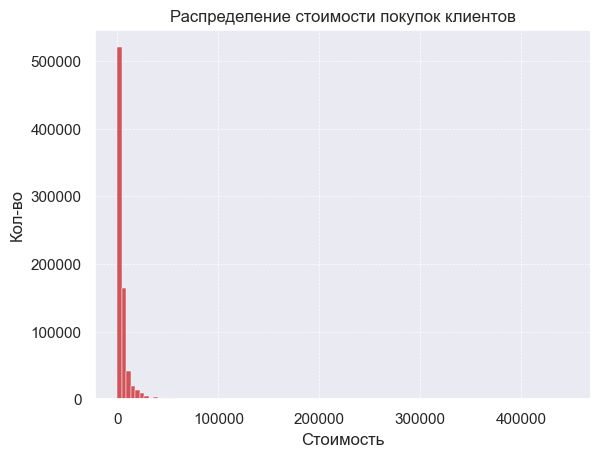

In [36]:
sns.histplot(df_purch['cost'], bins=100, color='#C92228')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.title('Распределение стоимости покупок клиентов')
plt.xlabel('Стоимость')
plt.ylabel('Кол-во')

Text(0, 0.5, 'Кол-во')

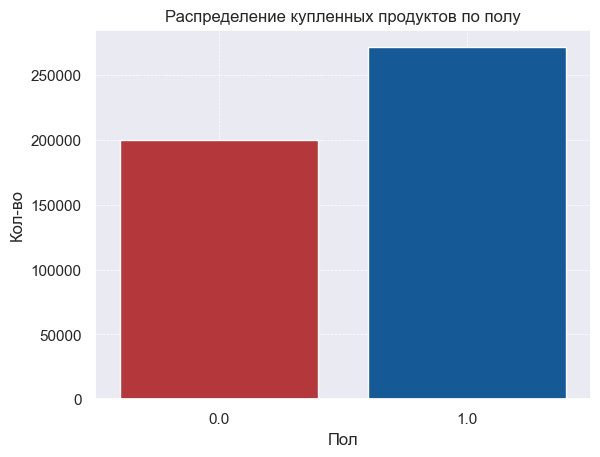

In [37]:
sns.countplot(x = df_purch['product_sex'],palette=['#C92228',"#005AAB"])
plt.grid(linestyle = '--', linewidth = 0.5)
plt.title('Распределение купленных продуктов по полу')
plt.xlabel('Пол')
plt.ylabel('Кол-во')

In [38]:
df_purch.duplicated().sum()

0

In [39]:
((df_purch.isna().sum() / len(df_purch)) * 100).sort_values(ascending=False)

product_sex    40.026454
colour         15.201587
id              0.000000
product         0.000000
cost            0.000000
base_sale       0.000000
dt              0.000000
dtype: float64

In [40]:
# Проверяем уникальные значения признаков в датафрейме

for column in df_purch.columns:
    print(column)
    print(df_purch[column].unique(), '\n')

id
[     0      3      4 ... 178001 178002 178004] 

product
['Велосипед горный женский Stern Mira 2.0 26"' 'Стол Outventure'
 'Набор Outventure: стол + 4 стула' ...
 'Клюшка детская Bauer Vapor 3X, Flex 55, P92'
 'Футболка мужская Reebok United By Fitness'
 'Бутсы мужские adidas Predator 19.3 TF'] 

colour
['белый/синий' 'зелёный' 'бежевый' ... 'бордовый/прозрачный/голубой'
 'синий/голубой/золотой/желтый' 'черный/циан'] 

cost
[ 13599   1499   4799 ...   5700  49899 174999] 

product_sex
[ 0. nan  1.] 

base_sale
[1 0] 

dt
[ 7 37 13 27 34  0  1  2 32  3  8 11 17 18 29 30  6 14 33 35 36 42 49 25
 39 55 56  4 26 28 45 51  5 15 50 52 12 16 19 21 22 23 31  9 58 41 44 57
 47 10 54 43 38 46 53 24 40 20 48] 



In [41]:
# Проверяем товары где не заполнен признак product_sex

df_purch['product'][df_purch['product_sex'].isnull()]

1                                           Стол Outventure
2                          Набор Outventure: стол + 4 стула
4         Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...
7                Роликовые коньки детские Roces Orlando III
8                                         Шлем FILA NRK FUN
                                ...                        
786236            Велосипед городской Stern Urban 28", 2022
786237              Палатка 3-местная Outventure Cadaques 3
786245                    Мини-степпер Torneo Massage S-231
786251        Бейсболка New Era 9Forty MLB New York Yankees
786258                                                Пакет
Name: product, Length: 314712, dtype: object

In [42]:
# Заполняем признак product_sex исходя из описания товаров

df_purch['product_sex'] = df_purch['product_sex'].fillna('3.0')

In [43]:
# Заполняем пропущенное значение признака цвет товара значением 'другой'

df_purch['colour'] = df_purch['colour'].fillna('другой')

In [44]:
df_purch.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,3.0,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,3.0,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,3.0,0,27


In [45]:
# Проверяем частоту значений в признаках

for column in df_purch.columns:
    print(column)
    print(df_purch[column].value_counts(), '\n')

id
20770     569
16910     522
20570     420
35091     330
131874    326
         ... 
165413      1
12748       1
165409      1
56134       1
89967       1
Name: id, Length: 104989, dtype: int64 

product
Брюки мужские Demix                                                                                                                    4961
Шорты мужские Demix                                                                                                                    4650
Футболка мужская Demix                                                                                                                 3644
Лиф женский Joss                                                                                                                       3378
Футболка женская Demix                                                                                                                 3252
                                                                                              

In [46]:
# Объединяем дублирующиеся значения цвета

df_purch['colour'] = df_purch['colour'].replace(['чёрный'], 'черный')

## A/B test evaluation

In [140]:
# Загружаем файлы которые содержат id клиентов участвовавших в A/B тесте

with open('data/ids_first_company_positive.txt') as f:
    positive = f.read()

In [141]:
elem_list = re.split(';|,| ', positive)

In [142]:
positive_id = []

for i in elem_list:
    if i.isdigit():
        positive_id.append(int(i))
        

In [148]:
len(positive_id)

4964

In [144]:
with open('data/ids_first_company_negative.txt') as f:
    negative = f.read()

In [145]:
elem_list = re.split(';|,| ', negative)

In [146]:
negative_id = []

for i in elem_list:
    if i.isdigit():
        negative_id.append(int(i))

In [147]:
len(negative_id)

4961